# Dual-Encoder Attention-Based Fusion Network

**Note:** In this notebook we can experiment with 

- Supervised vs Unsupervised
- Different Model(encoder+decoder) Architectures
- Custom Loss Functions
- Epochs and Learning Rate
- Different Targets 

**Note:** The images displayed is of authors own collected fingerprint and hence is released here.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms
from torchvision.transforms import functional as TF
from PIL import Image
import glob
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pytorch_msssim import ssim
from skimage.morphology import skeletonize
import random
from torchvision import models
import torch.optim as optim
from pytorch_msssim import ssim  
import re
import torch.fft as fft
from pytorch_msssim import ssim

In [40]:
def pad_and_resize(img: Image.Image, size=512):
    """Pad to square with black padding, then resize to (size,size)."""
    w, h = img.size
    pad_left = pad_right = pad_top = pad_bottom = 0

    if w > h:
        diff = w - h
        pad_top = diff // 2
        pad_bottom = diff - pad_top
    else:
        diff = h - w
        pad_left = diff // 2
        pad_right = diff - pad_left

    img_padded = TF.pad(img, padding=(pad_left, pad_top, pad_right, pad_bottom), padding_mode="constant", fill=0)

    img_resized = TF.resize(img_padded, (size, size))

    pad_info = {
        "orig_size": (h, w),
        "pad": (pad_top, pad_bottom, pad_left, pad_right),
        "resized_size": (size, size),
    }

    return img_resized, pad_info

def create_valid_mask(pad_info, size=512):
    """Create binary mask (1 = valid/original area, 0 = padding)."""
    h, w = pad_info["orig_size"]
    top, bottom, left, right = pad_info["pad"]

    mask = np.zeros((h + top + bottom, w + left + right), dtype=np.uint8)
    mask[top:top+h, left:left+w] = 1

    mask_resized = cv2.resize(mask, (size, size), interpolation=cv2.INTER_NEAREST)
    return torch.tensor(mask_resized, dtype=torch.float32)

class PadResizeToTensor:
    def __init__(self, size=512):
        self.size = size

    def __call__(self, img):
        img_resized, pad_info = pad_and_resize(img, self.size)
        mask = create_valid_mask(pad_info, self.size)
        mask = mask.unsqueeze(0)  
        return TF.to_tensor(img_resized), mask, pad_info

def undo_pad_and_resize(output, pad_info, mask=None):
    """
    Reverts network output (size×size) back to original image size
    using the valid mask from pad_and_resize.
    """
    if isinstance(output, torch.Tensor):
        output = output.detach().cpu().numpy()
        if output.ndim == 3 and output.shape[0] in [1, 3]:
            output = np.transpose(output, (1, 2, 0))

    h, w = pad_info["orig_size"]
    top, bottom, left, right = pad_info["pad"]
    padded_h, padded_w = h + top + bottom, w + left + right

    output_resized = cv2.resize(output, (padded_w, padded_h), interpolation=cv2.INTER_CUBIC)

    if mask is None:
        mask = np.zeros((padded_h, padded_w), dtype=np.uint8)
        mask[top:top+h, left:left+w] = 1
    elif isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()

    ys, xs = np.where(mask > 0)
    y1, y2 = ys.min(), ys.max() + 1
    x1, x2 = xs.min(), xs.max() + 1
    output_cropped = output_resized[y1:y2, x1:x2]
    output_final = cv2.resize(output_cropped, (w, h), interpolation=cv2.INTER_CUBIC)

    return output_final


In [ ]:
class FingerprintDataset(Dataset):
    def __init__(self, nf_dir, f_dir, fnf_dir, transform=None):
        self.nf_files = sorted(glob.glob(os.path.join(nf_dir, "*.tif")))
        self.f_files = sorted(glob.glob(os.path.join(f_dir, "*.tif")))
        self.fnf_files = sorted(glob.glob(os.path.join(fnf_dir, "*.tif"))) # If you want to keep a target, else don't require.
        self.transform = transform

    def __len__(self):
        return len(self.nf_files)

    def __getitem__(self, idx):
        nf_img = Image.open(self.nf_files[idx]).convert("RGB") 
        f_img = Image.open(self.f_files[idx]).convert("RGB") 
        fnf_img = Image.open(self.fnf_files[idx]).convert("RGB") 

        if self.transform:
            nf_img, nf_mask, nf_pad_info = self.transform(nf_img)
            f_img, f_mask, f_pad_info = self.transform(f_img)
            fnf_img, fnf_mask, fnf_pad_info = self.transform(fnf_img)
        else:
            nf_img = TF.to_tensor(nf_img)
            f_img = TF.to_tensor(f_img)
            fnf_img = TF.to_tensor(fnf_img)
            h, w = nf_img.shape[1], nf_img.shape[2]
            nf_mask = torch.ones((1, h, w), dtype=torch.float32)
            f_mask = torch.ones((1, h, w), dtype=torch.float32)
            fnf_mask = torch.ones((1, h, w), dtype=torch.float32)
            nf_pad_info, f_pad_info, fnf_pad_info = None, None, None

        return nf_img, f_img, fnf_img, nf_mask, f_mask, fnf_mask, nf_pad_info, f_pad_info, fnf_pad_info

batch_size = 8

nf_dir = "<DATASET>"
f_dir = "<DATASET>"
fnf_dir = "<DATASET>"

transform = PadResizeToTensor(size=512)

full_dataset = FingerprintDataset(nf_dir, f_dir, fnf_dir, transform=transform)

train_split = 0.7
val_split = 0.15
train_size = int(train_split * len(full_dataset))
val_size = int(val_split * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset = Subset(full_dataset, range(0, train_size))
val_dataset   = Subset(full_dataset, range(train_size, train_size + val_size))
test_dataset  = Subset(full_dataset, range(train_size + val_size, len(full_dataset)))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Dual Encoder Attention Fusion Net

In [ ]:
# Basic Conv Block
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, stride, 1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

# Encoder
class Encoder(nn.Module):
    def __init__(self, in_ch=3):
        super().__init__()
        self.enc1 = ConvBlock(in_ch, 32)
        self.enc2 = ConvBlock(32, 64, stride=2)
        self.enc3 = ConvBlock(64, 128, stride=2)
        self.enc4 = ConvBlock(128, 256, stride=2)
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        return [e1, e2, e3, e4]

# Attention Fusion
class AttentionFusion(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Conv2d(ch * 2, ch, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch, 2, 1),
            nn.Softmax(dim=1)
        )
    def forward(self, f1, f2):
        w = self.attn(torch.cat([f1, f2], dim=1))
        return f1 * w[:, 0:1] + f2 * w[:, 1:2]

# Frequency + Edge-Aware Decoder
class Decoder(nn.Module):
    def __init__(self, in_ch=256, out_ch=3):
        super().__init__()
        self.up1 = nn.ConvTranspose2d(in_ch, 128, 4, 2, 1)
        self.up2 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.up3 = nn.ConvTranspose2d(64, 32, 4, 2, 1)
        self.out = nn.Conv2d(32, out_ch, 3, 1, 1)
        self.edge_enhance = nn.Conv2d(out_ch, out_ch, 3, 1, 1, bias=False)
        self.edge_enhance.weight.data.fill_(0)
        self.edge_enhance.weight.data[:, :, 1, 1] = 1 

    def forward(self, x):
        x = F.relu(self.up1(x))
        x = F.relu(self.up2(x))
        x = F.relu(self.up3(x))
        x = torch.sigmoid(self.out(x))

        x_fft = fft.fftshift(fft.fft2(x, norm='ortho'))
        mag = torch.log(1 + torch.abs(x_fft))
        mag = mag / (torch.max(mag) + 1e-6)
        hf_weight = 1 + 0.2 * mag
        x = x * hf_weight

        edge = self.edge_enhance(x)
        return x + 0.1 * edge

# Full Model
class DualEncoderFusionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flash_enc = Encoder(3)
        self.nonflash_enc = Encoder(3)
        self.fusions = nn.ModuleList([
            AttentionFusion(32),
            AttentionFusion(64),
            AttentionFusion(128),
            AttentionFusion(256)
        ])
        self.decoder = Decoder(256, 3)

    def forward(self, flash, nonflash, mask):
        f1 = self.flash_enc(flash)
        f2 = self.nonflash_enc(nonflash)
        fused = [self.fusions[i](f1[i], f2[i]) for i in range(4)]
        out = self.decoder(fused[-1])

        mask_up = F.interpolate(mask, size=out.shape[2:], mode='nearest')
        return out * mask_up

# Simple MaskedFusionNet - (for experiments)

In [45]:
class MaskedFusionNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(6, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, 2, 1),   
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, 2, 1),  
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, 2, 1), 
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), 
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),   
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, 3, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x, mask):
        x = x * mask
        # Encoder
        x = self.encoder(x)
        # Decoder
        x = self.decoder(x)
        mask_up = F.interpolate(mask, size=x.shape[2:], mode='nearest')
        x = x * mask_up
        return x


# Custom Loss

In [ ]:
class VGGPerceptual(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_FEATURES).features
        self.features = nn.Sequential(*list(vgg.children())[:16])  # conv3_3
        for p in self.features.parameters():
            p.requires_grad = False
    def forward(self, x):
        return self.features(x)

def combined_loss(pred, target, mask, vgg, alpha=0.6, beta=0.1, gamma=0.15, delta=0.1, epsilon=0.05):
    if target.shape[2:] != pred.shape[2:]:
        target = F.interpolate(target, size=pred.shape[2:], mode='bilinear', align_corners=False)
    if mask.shape[2:] != pred.shape[2:]:
        mask = F.interpolate(mask, size=pred.shape[2:], mode='nearest')
    mask_exp = mask.expand_as(pred)

    # L1 
    l1 = (torch.abs(pred - target) * mask_exp).sum() / mask_exp.sum()

    # SSIM 
    ssim_val = 1 - ssim(pred * mask_exp, target * mask_exp, data_range=1.0, size_average=True)

    # Edge Loss 
    def grad_loss(x, y):
        dx_x = x[:, :, :, 1:] - x[:, :, :, :-1]
        dy_x = x[:, :, 1:, :] - x[:, :, :-1, :]
        dx_y = y[:, :, :, 1:] - y[:, :, :, :-1]
        dy_y = y[:, :, 1:, :] - y[:, :, :-1, :]
        return F.l1_loss(dx_x, dx_y) + F.l1_loss(dy_x, dy_y)
    e_loss = grad_loss(pred * mask_exp, target * mask_exp)

    # Fourier-based high-frequency reward
    def fft_highfreq_reward(x):
        xf = fft.fftshift(fft.fft2(x, norm='ortho'))
        mag = torch.abs(xf)
        B, C, H, W = mag.shape
        yy, xx = torch.meshgrid(
            torch.linspace(-1, 1, H, device=x.device),
            torch.linspace(-1, 1, W, device=x.device),
            indexing='ij'
        )
        freq_radius = torch.sqrt(xx**2 + yy**2)  
        freq_weight = freq_radius / freq_radius.max() 

        weighted_energy = (mag * freq_weight).mean()  
        return weighted_energy
    # Reward model for *more* high-frequency energy (not penalize)
    hf_pred = fft_highfreq_reward(pred * mask_exp)
    hf_target = fft_highfreq_reward(target * mask_exp)
    f_loss = torch.relu(hf_target - hf_pred)  

    # Perceptual Loss (VGG16 conv3_3) 
    with torch.no_grad():
        feat_t = vgg(target)
    feat_p = vgg(pred)
    p_loss = F.l1_loss(feat_p, feat_t)

    total = alpha * l1 + beta * ssim_val + gamma * f_loss + delta * e_loss + epsilon * p_loss # can modify
    return total

# Training

In [47]:
device = torch.device("mps") # replace with cuda or mps or cpu
torch.mps.empty_cache()
mask_fusion_model = DualEncoderFusionNet().to(device)
vgg = VGGPerceptual().to(device).eval()
optimizer = optim.Adam(mask_fusion_model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
num_epochs = 30
train_losses, val_losses = [], []

In [ ]:
best_val_loss = float('inf')
best_model_wts = None 
best_model_path = "best_model.pt" # change acc to your file

for epoch in range(num_epochs):
    mask_fusion_model.train()
    running_loss = 0.0

    for nf_img, f_img, fnf_img, nf_mask, f_mask, fnf_mask, nf_pad, f_pad, fnf_pad in tqdm(train_loader):
        nf_img = nf_img.to(device)
        f_img  = f_img.to(device)
        mask   = nf_mask.to(device)
        target = fnf_img.to(device)

        optimizer.zero_grad()

        output = mask_fusion_model(f_img, nf_img, mask)
        loss = combined_loss(output, target, mask, vgg)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * target.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    mask_fusion_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for nf_img, f_img, fnf_img, nf_mask, f_mask, fnf_mask, nf_pad, f_pad, fnf_pad in tqdm(val_loader):
            nf_img = nf_img.to(device)
            f_img  = f_img.to(device)
            mask   = nf_mask.to(device)
            target = fnf_img.to(device)
            
            output = mask_fusion_model(f_img, nf_img, mask)
            loss = combined_loss(output, target, mask, vgg)
            val_loss += loss.item() * target.size(0)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    scheduler.step(epoch_val_loss)

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_wts = mask_fusion_model.state_dict().copy()
        torch.save(best_model_wts, best_model_path)
        print(f"** Best model updated at epoch {epoch+1} **")

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}")

mask_fusion_model.load_state_dict(best_model_wts)

# Plot train & val loss
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Curve")
plt.legend()
plt.show()

best_model = mask_fusion_model
print(f"Best model saved at: {best_model_path}")

# Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.3185257..1.0552411].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0046922457..1.0645849].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03368607..1.0560681].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.053087298..1.070848].


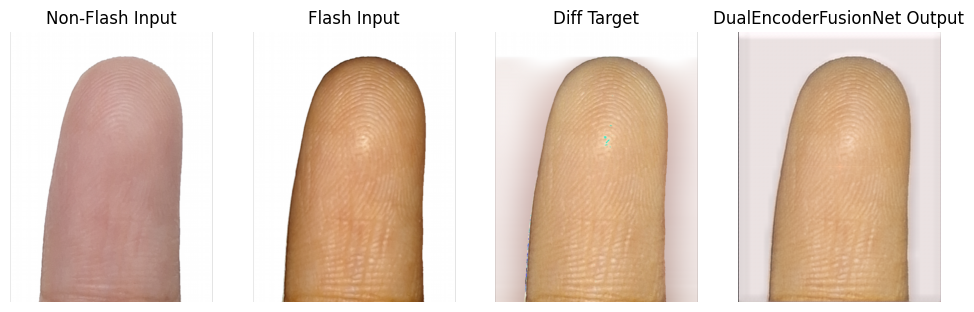

In [56]:
mask_fusion_model.load_state_dict(torch.load(best_model_path))

test_index = 0
# Test & Visualization
mask_fusion_model.eval()
nf_img, f_img, fnf_img, nf_mask, f_mask, fnf_mask, nf_pad, f_pad, fnf_pad = train_loader.dataset[test_index]

nf_img_batch = nf_img.unsqueeze(0).to(device)
f_img_batch  = f_img.unsqueeze(0).to(device)
fnf_img = fnf_img.to(device)
mask_batch   = nf_mask.unsqueeze(0).to(device)

with torch.no_grad():
    output = mask_fusion_model(f_img_batch, nf_img_batch, mask_batch)
    out_sample = output.squeeze(0).permute(1,2,0).cpu().numpy()

nf_sample  = nf_img.permute(1,2,0).cpu().numpy()
f_sample   = f_img.permute(1,2,0).cpu().numpy()
fnf_sample = fnf_img.permute(1,2,0).cpu().numpy()

nf_sample_upad = undo_pad_and_resize(nf_sample, nf_pad)
f_sample_upad = undo_pad_and_resize(f_sample, f_pad)
fnf_sample_upad = undo_pad_and_resize(fnf_sample, fnf_pad)
out_sample_upad = undo_pad_and_resize(out_sample, nf_pad)

plt.figure(figsize=(12,4))
plt.subplot(1,4,1)
plt.imshow(nf_sample_upad)
plt.title("Non-Flash Input")
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(f_sample_upad)
plt.title("Flash Input")
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(fnf_sample_upad)
plt.title("Diff Target")
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(out_sample_upad)
plt.title("DualEncoderFusionNet Output")
plt.axis('off')
plt.show()
